In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../scripts/")

# librairies perso
from import_data import import_data
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure

In [2]:
data = import_data()

In [3]:
def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

In [4]:
CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/EEX.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

In [5]:
# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

In [6]:
data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 38 , 49]))]

In [7]:
def creation_model(df, xarg, yarg, sep):
    train_size = int(len(df.groupby("id_client").get_group(1)) * sep)
    date = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
    train = df[df["horodate"] <= date]
    test = df[df["horodate"] > date]
    X_train = train.copy()[xarg]
    Y_train = train.copy()[yarg]
    X_test = test.copy()[xarg]
    Y_test = test.copy()[yarg]

    # création du model
    model = LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    comp = pd.DataFrame(Y_test.copy())
    comp["pred"] = y_pred
    comp["id_client"] = X_test["id_client"]
    evaluation_model = []

    evaluation_model = []
    for i in df["id_client"].unique():
        y = comp.groupby("id_client").get_group(i)["pred"]
        y2 = comp.groupby("id_client").get_group(i)["real_consumption"]
        evaluation_model.append(metrics(y2, y))
    return model, evaluation_model

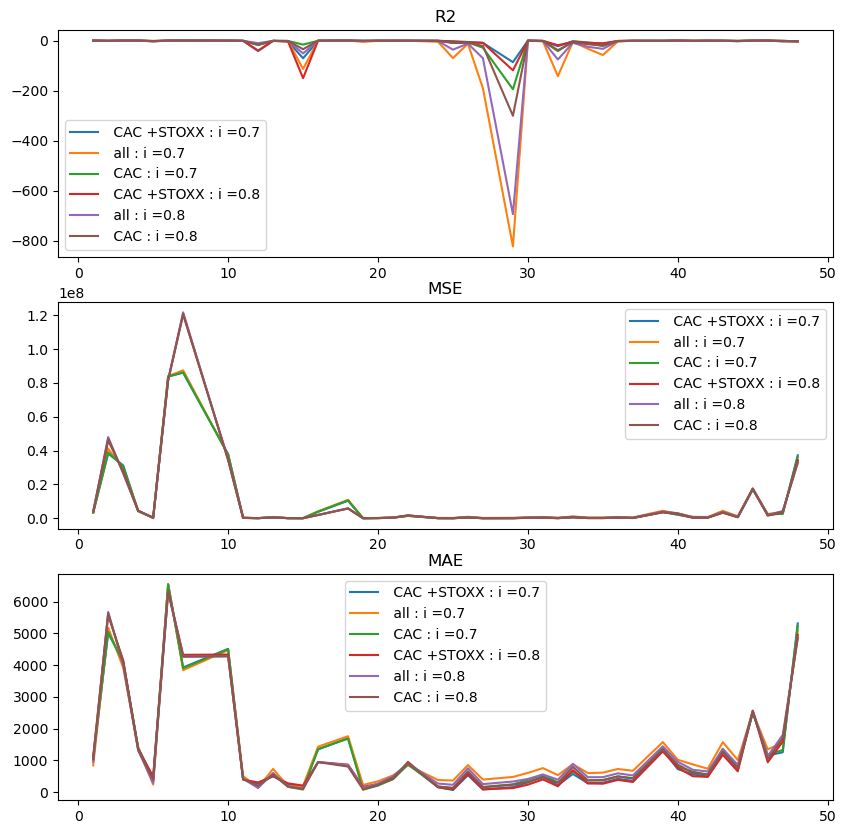

In [8]:
X = data["id_client"].unique()

evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(7,9): 
    model, eval_model_CAX_STOXX = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    model, eval_model_all = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "BFX", "AEX"], ["real_consumption"], i/10)
    model, eval_model_CAC = creation_model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], i/10)
    for j in range(3): 
        ax[j].plot(X, [x[j] for x in eval_model_CAX_STOXX], label = f" CAC +STOXX : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_all], label = f" all : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_CAC], label = f" CAC : i ={i/10}")
        ax[j].legend()

## Random Forest

In [9]:
def creation_model_rf(df, xarg, yarg, sep):
    train_size = int(len(df.groupby("id_client").get_group(1)) * sep)
    date = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
    train = df[df["horodate"] <= date]
    test = df[df["horodate"] > date]
    X_train = train.copy()[xarg]
    Y_train = np.array(train.copy()[yarg]).ravel()
    X_test = test.copy()[xarg]
    Y_test = np.array(test.copy()[yarg]).ravel()

    # création du model
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    comp = pd.DataFrame(Y_test.copy(), columns = ["real_consumption"], index = X_test.index)
    comp["pred"] = y_pred
    comp["id_client"] = X_test["id_client"]
    evaluation_model = []

    
    for i in df["id_client"].unique():
        y = comp.groupby("id_client").get_group(i)["pred"]
        y2 = comp.groupby("id_client").get_group(i)["real_consumption"]
        evaluation_model.append(metrics(y2, y))
    
    return model, evaluation_model

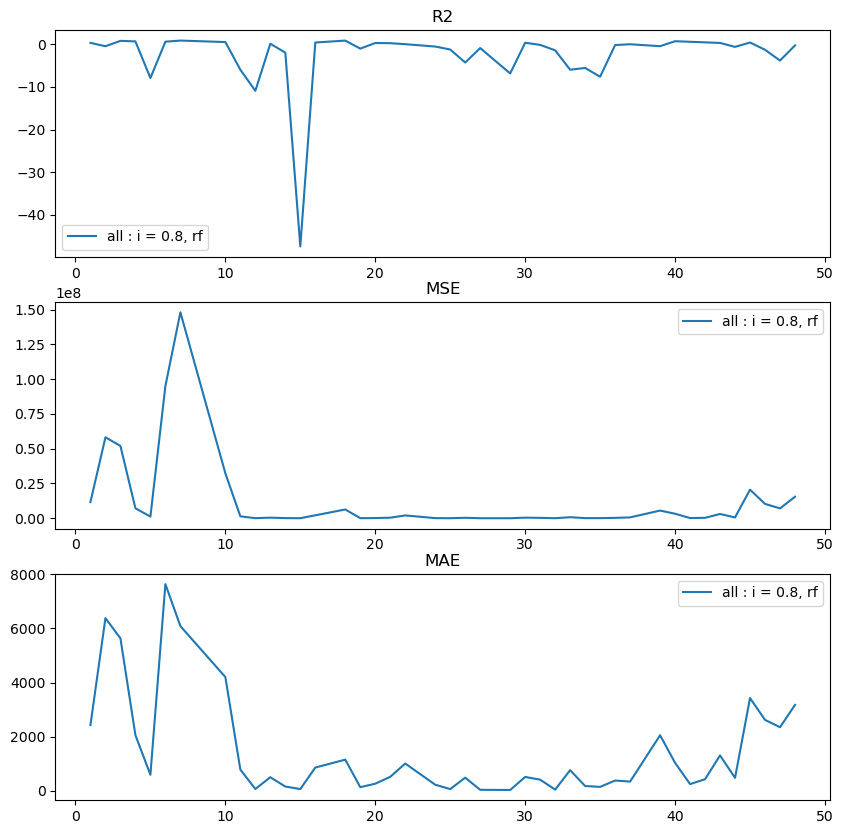

In [10]:
X = data["id_client"].unique()
evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(8,9): 
    #model, eval_model_CAX_STOXX_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    model, eval_model_all_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    #model, eval_model_CAC_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], i/10)
    for j in range(3): 
        #ax[j].plot(X, [x[j] for x in eval_model_CAX_STOXX_rf], label = f" CAC +STOXX : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_all_rf], label = f"all : i = {i/10}, rf")
        #ax[j].plot(X, [x[j] for x in eval_model_CAC_rf], label = f" CAC : i ={i/10}")
        ax[j].legend()

In [11]:
feature_importance = pd.DataFrame(model.feature_importances_).T
feature_importance.columns = model.feature_names_in_

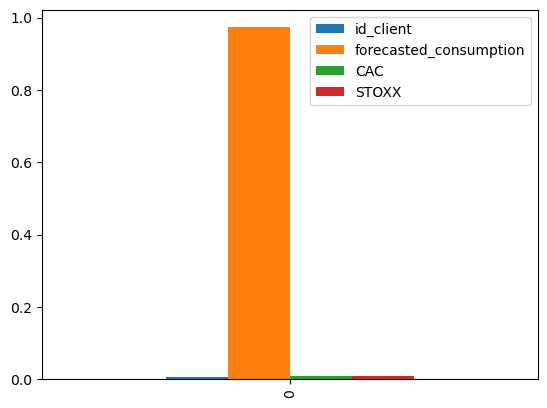

In [12]:
feature_importance.plot.bar();

In [13]:
clients = [data.groupby("id_client").get_group(i) for i in data["id_client"].unique()]

In [14]:
clients[0]

,id_client,horodate,real_consumption,forecasted_consumption,prediction,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,1,2021-01-01,8396.00,8400.0,8323.319457,5573.200195,625.190002,3641.530029,3580.909912,122.727272,5.32
1,1,2021-01-02,8395.00,8400.0,8194.785384,5573.200195,625.190002,3641.530029,3580.909912,122.727272,5.32
2,1,2021-01-03,8396.00,8400.0,8183.265980,5573.200195,625.190002,3641.530029,3580.909912,122.727272,5.32
3,1,2021-01-04,8397.00,8400.0,8420.826672,5614.040039,632.020020,3671.080078,3565.679932,123.590912,5.35
4,1,2021-01-05,8395.73,8400.0,8123.422185,5561.600098,629.940002,3645.760010,3554.239990,123.136360,5.26
...,...,...,...,...,...,...,...,...,...,...,...
756,1,2023-01-27,0.00,0.0,8138.044274,7085.470215,749.309998,3868.540039,4177.259766,147.919998,3.88
757,1,2023-01-28,0.00,0.0,8330.466932,7085.470215,749.309998,3868.540039,4177.259766,147.919998,3.88
758,1,2023-01-29,0.00,0.0,8339.560999,7085.470215,749.309998,3868.540039,4177.259766,147.919998,3.88
759,1,2023-01-30,0.00,0.0,8285.731556,7054.240234,743.090027,3848.070068,4166.750000,147.899994,3.87


In [15]:
models, eval_model = complet_process(data,["forecasted_consumption", "CAC", "BFX"], ["real_consumption"], 0.8, group = True)

## Test nouvelle librairie

In [16]:
model1, eval_model1 = complet_process(data, ["forecasted_consumption", "CAC", "BFX", "STOXX", "AEX"], ["real_consumption"], 0.8, group = True, random_forest=False, n_estimators = 150)
model2, eval_model2 = complet_process(data, ["forecasted_consumption"], ["real_consumption"], 0.8,group = True, random_forest=False, n_estimators = 150)

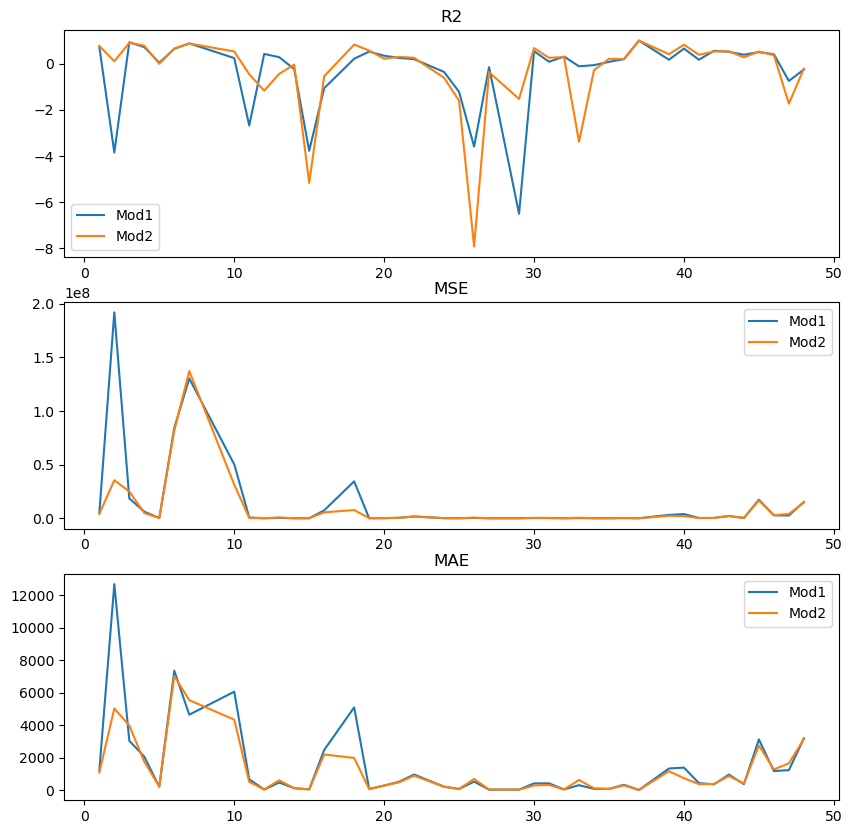

In [17]:
X = data["id_client"].unique()
evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")

for j in range(3): 
    ax[j].plot(X, [x[j] for x in eval_model1], label = f"Mod1")
    ax[j].plot(X, [x[j] for x in eval_model2], label = f"Mod2")
    ax[j].legend()

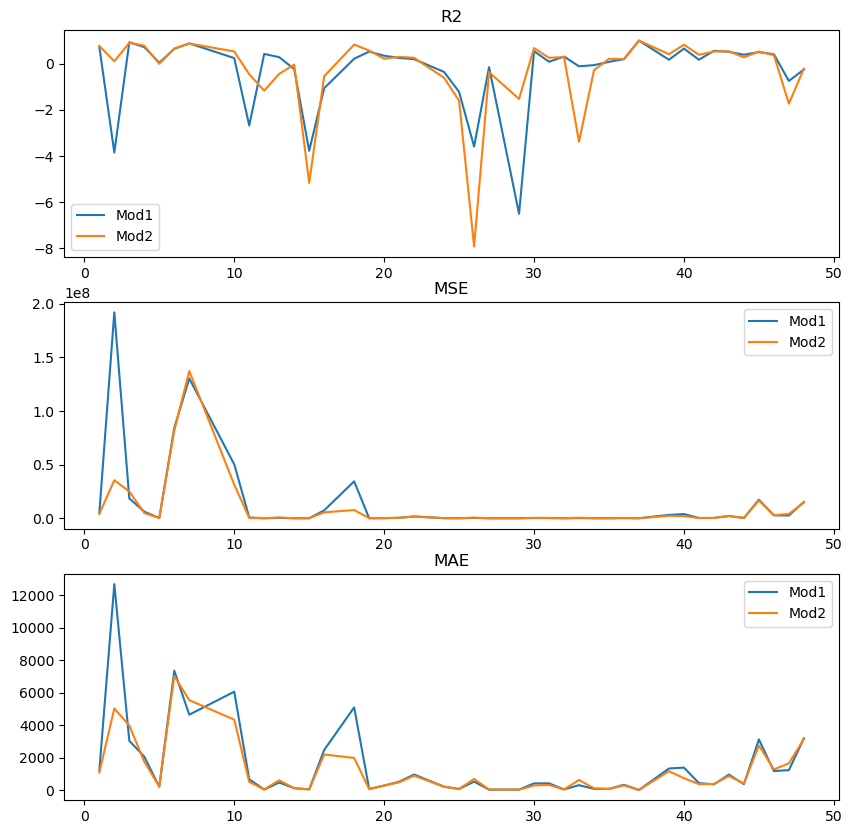

In [18]:
display_mesure(data, [eval_model1, eval_model2], [f"Mod1", "Mod2"]);

In [19]:
tab_mesure(eval_model1).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,42.000000
mean,-0.300467,1.381437e+07,1519.287576
std,1.545890,3.753212e+07,2490.124810
min,-6.498592,0.000000e+00,0.000000
25%,-0.211319,3.770132e+04,133.494339
50%,0.204961,2.825266e+05,442.850959
75%,0.508860,4.532200e+06,1366.160625
max,1.000000,1.921359e+08,12699.634173


In [20]:
tab_mesure(eval_model2).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,42.000000
mean,-0.290921,9.112184e+06,1224.716617
std,1.683019,2.498902e+07,1694.093272
min,-7.913336,0.000000e+00,0.000000
25%,-0.422255,3.711570e+04,129.056398
50%,0.253333,3.237972e+05,484.936010
75%,0.534615,4.047430e+06,1550.807298
max,1.000000,1.373172e+08,7028.811790


## Prédiction de l'erreur

In [21]:
data["error"] = data["forecasted_consumption"] - data["real_consumption"]

In [22]:
model1, eval_model1 = complet_process(data, ["forecasted_consumption",], ["error"], 0.7, group = True, random_forest=False, n_estimators = 150)
model2, eval_model2 = complet_process(data, ["forecasted_consumption","STOXX"], ["error"], 0.7, group = True, random_forest=False, n_estimators = 150)
model3, eval_model3 = complet_process(data, ["forecasted_consumption","CAC", "STOXX"], ["error"], 0.7, group = True, random_forest=False, n_estimators = 150)
model4, eval_model4 = complet_process(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], 0.7, group = False, random_forest=False, n_estimators=150)

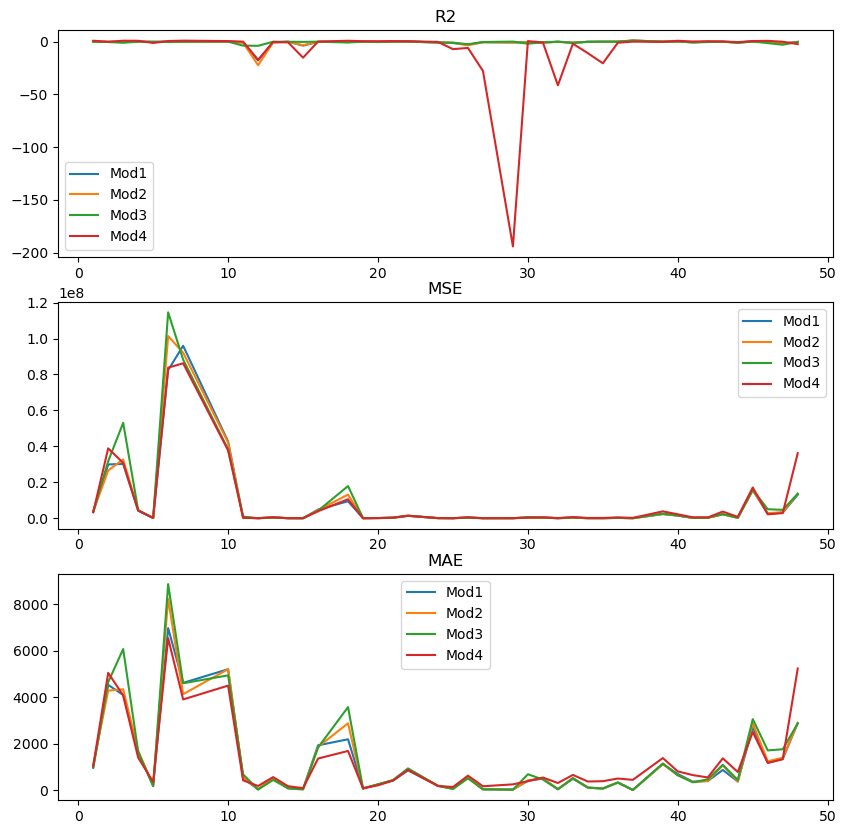

In [23]:
display_mesure(data, [eval_model1, eval_model2, eval_model3, eval_model4], [f"Mod1", "Mod2", "Mod3", "Mod4"]);

In [24]:
tab_mesure(eval_model).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,42.000000
mean,-0.016203,1.082255e+07,1336.550887
std,0.879780,2.827568e+07,2052.853148
min,-3.588215,0.000000e+00,0.000000
25%,-0.272200,4.023273e+04,134.861200
50%,0.208012,3.406076e+05,502.113929
75%,0.518477,3.905636e+06,1611.680549
max,1.000000,1.201278e+08,9619.030154


In [25]:
tab_mesure(eval_model2).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,4.200000e+01
mean,-1.020686,8.746872e+06,1.233116e+03
std,3.466120,2.196772e+07,1.760948e+03
min,-22.344104,3.807791e-28,1.895165e-14
25%,-0.757175,2.508516e+04,1.213846e+02
50%,-0.245753,3.767927e+05,5.010589e+02
75%,-0.084163,3.578501e+06,1.352082e+03
max,1.000000,1.013789e+08,8.244120e+03


In [26]:
tab_mesure(eval_model3).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,4.200000e+01
mean,-0.629125,9.694249e+06,1.347166e+03
std,1.028723,2.375211e+07,1.951997e+03
min,-3.964137,2.834514e-28,1.451812e-14
25%,-0.842176,2.523207e+04,1.184449e+02
50%,-0.203423,3.182873e+05,4.812099e+02
75%,-0.059814,4.359753e+06,1.690014e+03
max,1.000000,1.145671e+08,8.869971e+03


In [27]:
tab_mesure(eval_model4).describe()

,R2,MSE,MAE
count,42.000000,4.200000e+01,42.000000
mean,-8.089835,8.922592e+06,1270.669680
std,30.680590,2.024042e+07,1610.316410
min,-194.111267,6.757057e+03,72.489397
25%,-1.776404,1.467905e+05,350.363091
50%,-0.075822,4.832491e+05,585.576098
75%,0.512191,3.789278e+06,1361.076424
max,0.923281,8.620542e+07,6540.798379


## Prendre en compte les dates

In [28]:
data["day"] = data['horodate'].dt.day
data["month"] = data["horodate"].dt.month
data["day_cos"] = np.cos(data["day"])
data["day_sin"] = np.sin(data["day"])
data["month_cos"] = np.cos(data["month"])
data["month_sin"] = np.sin(data["month"])

In [45]:
model1, eval_model1 = complet_process(data, ["forecasted_consumption"], ["real_consumption"], 0.8, group = True, random_forest=False, n_estimators=150)
model2, eval_model2 = complet_process(data, ["forecasted_consumption", "CAC", "BFX", "AEX", "STOXX"], ["real_consumption"], 0.8, group = True, random_forest=False, n_estimators=150)
model3, eval_model3 = complet_process(data, ["id_client", "forecasted_consumption"], ["real_consumption"], 0.8, group = False)

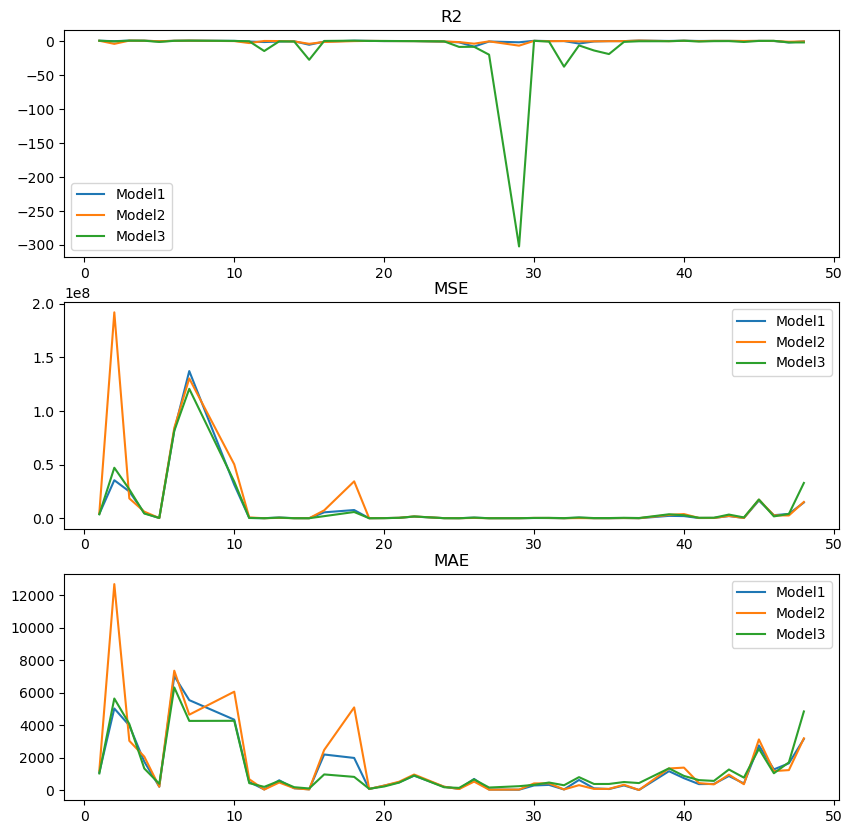

In [30]:
display_mesure(data, [eval_model1, eval_model2, eval_model3], [f"Model1", "Model2", "Model3"]);

In [31]:
del eval_model2[1]
del eval_model1[1]
del eval_model3[1]
del eval_model2[5]
del eval_model1[5]
del eval_model3[5]

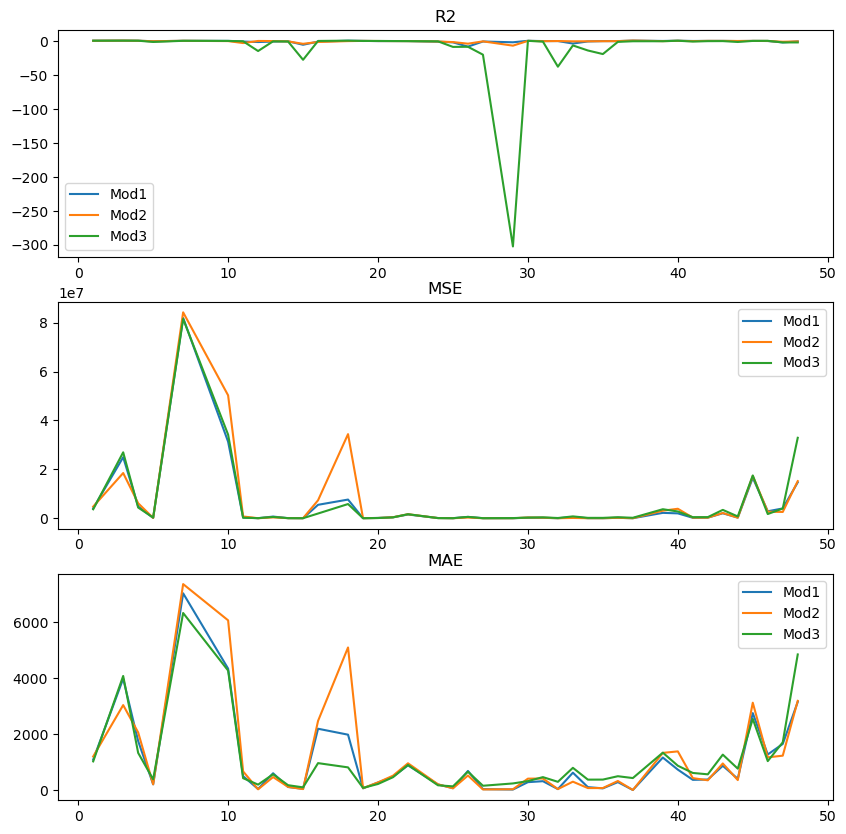

In [32]:
X = data["id_client"].unique()
indexes = [1, 5]
X = np.delete(X, indexes)
eval_model_list = [eval_model1, eval_model2, eval_model3]
titles = ["Mod1", "Mod2", "Mod3"]
fig, ax = plt.subplots(3, figsize=(10, 10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for eval_model, title in zip(eval_model_list, titles):
    r2, mse, mae = export_mesure(eval_model)
    ax[0].plot(X, r2, label=title)
    ax[0].legend()
    ax[1].plot(X, mse, label=title)
    ax[1].legend()
    ax[2].plot(X, mae, label=title)
    ax[2].legend()

## Gradient boosting

In [64]:
df = data.copy()
lim_date = 0.8
xargs = ["id_client", "forecasted_consumption", "CAC", "day", "month"]
yargs = ["error"]


n = df["id_client"].max()
train_size = int(len(df.groupby("id_client").get_group(1)) * lim_date)
date_lim = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
train = df[df["horodate"] <= date_lim]
test = df[df["horodate"] > date_lim]
X_train = train.copy()[xargs]
Y_train = train.copy()[yargs]
X_test = test.copy()[xargs]
Y_test = test.copy()[yargs]

In [65]:
from sklearn.tree import DecisionTreeRegressor  # pour les arbres de régression
from sklearn.ensemble import RandomForestRegressor  # pour les forêts aléatoires
from sklearn.ensemble import GradientBoostingRegressor  # pour les boosters

model = GradientBoostingRegressor()

In [66]:
model.fit(X_train, np.array(Y_train).ravel())
y_pred = model.predict(X_test)

comp = pd.DataFrame(Y_test.copy())
comp["pred"] = y_pred
comp["id_client"] = X_test["id_client"]
evaluation_model = []

evaluation_model = []
for i in df["id_client"].unique():
    y = comp.groupby("id_client").get_group(i)["pred"]
    y2 = comp.groupby("id_client").get_group(i)[yargs]
    evaluation_model.append(metrics(y2, y))

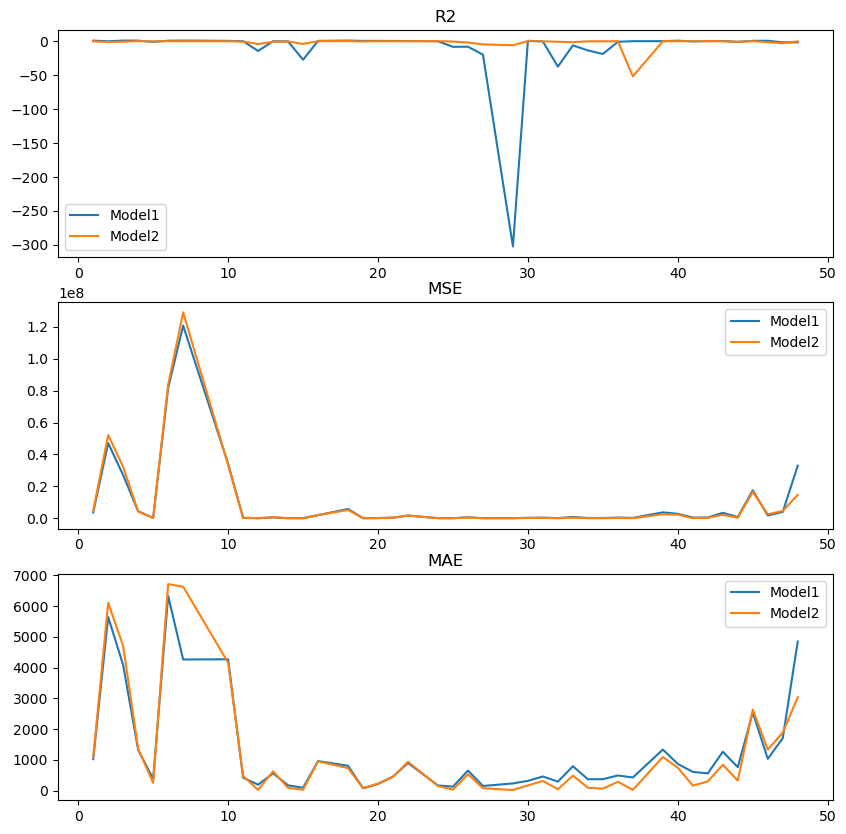

In [67]:
display_mesure(data, [eval_model3, evaluation_model], [f"Model1", "Model2"]);